<div style="
  background-color:#0F172A;
  border-left:5px solid #3B82F6;
  padding:16px;
  border-radius:10px;
">

<span style="
  background:#1E293B;
  color:#60A5FA;
  padding:4px 10px;
  border-radius:999px;
  font-size:12px;
  font-weight:600;
">
CACHE · IMPLEMENTATION
</span>

## 🔵 **PART 1: Introduction to Semantic Caching for LLM Applications**

1. Data visualization  
2. Building a cache from scratch (no libraries)  
3. Comparing different caching strategies:
    - Exact Match  
    - Fuzzy Match  
    - Semantic Cache  
4. Understanding distance metrics and thresholds  

<hr style="border:0; border-top:1px solid #1E293B; margin:16px 0;" />

<p style="
  font-size:13px;
  color:#CBD5E1;
  line-height:1.6;
">
<strong>Acknowledgement:</strong>  
This notebook and the accompanying evaluation dashboard were inspired by the 
<a href="https://www.deeplearning.ai/short-courses/semantic-caching-for-ai-agents/" target="_blank" style="color:#60A5FA; text-decoration:none;">
Semantic Caching for AI Agents
</a> short course by DeepLearning.AI.  
I used several ideas and portions of their reference code alongside my own implementations.  
Full credit and thanks to the course creators for the foundational concepts and examples.
</p>

</div>

### **Load the Necessary Libraries**

In [45]:
from sentence_transformers import SentenceTransformer
from difflib import SequenceMatcher
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from typing import List, Tuple, Optional, Dict, Callable
from dataclasses import dataclass, field
import time
import warnings
from pyprojroot import here
warnings.filterwarnings('ignore')

### **Implement the Data Loader**

In [46]:
print("\n📂 Setting up data infrastructure...\n")


@dataclass
class CacheResult:
    """Standardized result for cache lookups."""
    prompt: str
    response: str
    vector_distance: float
    cosine_similarity: float

    # Optional metadata for rerankers
    reranker_type: Optional[str] = None
    reranker_score: Optional[float] = None
    reranker_reason: Optional[str] = None


@dataclass
class CacheResults:
    """Container for query results with multiple potential matches."""
    query: str
    matches: List[CacheResult] = field(default_factory=list)

    def __repr__(self):
        return f"CacheResults(query='{self.query}', matches={len(self.matches)})"

    @property
    def hit(self) -> bool:
        return len(self.matches) > 0

    @property
    def best_match(self) -> Optional[CacheResult]:
        return self.matches[0] if self.matches else None


class FAQDataContainer:
    """
    Data container that manages FAQ data and test queries.

    This pattern keeps data loading and labeling logic in one place,
    making it easy to swap datasets or add new test cases.
    """

    def __init__(self, faq_path: str = here("data/faq_seed.csv"),
                 test_path: str = here("data/test_dataset.csv")):
        self.faq_df = pd.read_csv(faq_path)
        self.test_df = pd.read_csv(test_path)

        print(f"✅ Loaded {len(self.faq_df)} FAQ entries")
        print(f"✅ Loaded {len(self.test_df)} test queries")
        print(f"   - Should hit cache: {self.test_df['cache_hit'].sum()}")
        print(f"   - Should miss cache: {(~self.test_df['cache_hit']).sum()}")

    def get_qa_pairs(self) -> List[Tuple[str, str]]:
        """Get all Q&A pairs for cache hydration."""
        return list(zip(self.faq_df["question"], self.faq_df["answer"]))

    def get_test_queries(self) -> List[str]:
        """Get all test queries."""
        return self.test_df["question"].tolist()

    def _resolve_question(self, q: str) -> Optional[str]:
        """Resolve a test query to its expected FAQ match."""
        matches = self.test_df[self.test_df["question"] == q]
        if len(matches) != 1:
            return None

        src_question_id = matches["src_question_id"].iloc[0]
        should_hit = matches["cache_hit"].iloc[0]

        if not should_hit:
            return None

        return self.faq_df.iloc[src_question_id]["question"]

    def label_cache_hits(self, cache_results: List) -> np.ndarray:
        """
        Label cache results as correct (True) or incorrect (False).

        A result is correct if:
        - Query should miss AND cache missed, OR
        - Query should hit AND cache hit the RIGHT question
        """
        results = []
        test_qs = set(self.test_df["question"].tolist())

        for res in cache_results:
            expected_hit = self._resolve_question(res.query)
            actual_hit = res.matches[0].prompt if res.matches else None

            # If the actual hit is also a test query, resolve it
            if actual_hit is not None and actual_hit in test_qs:
                actual_hit = self._resolve_question(actual_hit)

            results.append(expected_hit == actual_hit)

        return np.array(results)


📂 Setting up data infrastructure...



### **Load the data and Check Some Entries**

In [47]:
data = FAQDataContainer()

✅ Loaded 8 FAQ entries
✅ Loaded 80 test queries
   - Should hit cache: 24
   - Should miss cache: 56


In [48]:
print("Number of FAQ entries:", data.faq_df.shape)
print("Column names in FAQ data:", data.faq_df.columns.tolist())
print("FAQ column types:", data.faq_df.dtypes)
data.faq_df.style

Number of FAQ entries: (8, 3)
Column names in FAQ data: ['id', 'question', 'answer']
FAQ column types: id           int64
question    object
answer      object
dtype: object


,id,question,answer
0,0,How do I get a refund?,"To request a refund, visit your orders page and select **Request Refund**. Refunds are processed within 3-5 business days."
1,1,Can I reset my password?,Click **Forgot Password** on the login page and follow the email instructions. Check your spam folder if you don't see the email.
2,2,Where is my order?,Use the tracking link sent to your email after shipping. Orders typically arrive within 2-7 business days depending on your location.
3,3,How long is the warranty?,All electronic products include a 12-month warranty from the purchase date. Extended warranties are available for purchase.
4,4,Do you ship internationally?,"Yes, we ship to over 50 countries worldwide. International shipping fees and delivery times vary by destination."
5,5,How do I cancel my subscription?,Go to Account Settings > Subscriptions and click **Cancel Subscription**. You'll retain access until your current billing period ends.
6,6,What payment methods do you accept?,"We accept all major credit cards, PayPal, Apple Pay, Google Pay, and bank transfers for orders over $100."
7,7,Can I change my delivery address?,You can update your delivery address before your order ships. Go to Orders > Modify Delivery Address.


In [49]:
print("Number of test queries along with the cache hit labels:", data.test_df.shape)
print("Column names in test data:", data.test_df.columns.tolist())
print("FAQ column types:", data.test_df.dtypes)
data.test_df.head(20).style

Number of test queries along with the cache hit labels: (80, 4)
Column names in test data: ['question', 'answer', 'src_question_id', 'cache_hit']
FAQ column types: question           object
answer             object
src_question_id     int64
cache_hit            bool
dtype: object


,question,answer,src_question_id,cache_hit
0,What's the process for getting my money back?,"To request a refund, visit your orders page and select **Request Refund**. Refunds are processed within 3-5 business days.",0,True
1,How can I request a refund for my purchase?,"To request a refund, visit your orders page and select **Request Refund**. Refunds are processed within 3-5 business days.",0,True
2,What steps do I follow to return an item for money back?,"To request a refund, visit your orders page and select **Request Refund**. Refunds are processed within 3-5 business days.",0,True
3,What's your refund policy for digital products?,Digital products are non-refundable except in cases of technical defects or billing errors.,0,False
4,How much does it cost to process a refund?,"Refund processing is free for most payment methods, though bank transfers may incur a $5 processing fee.",0,False
5,Can I get a refund if I changed my mind?,Refunds for change of mind are only available within 14 days for unused products in original packaging.,0,False
6,What's the weather like in Tokyo today?,I don't have access to real-time weather data. Please check a weather service for current forecasts.,0,False
7,How do you make sourdough bread?,"Mix flour, water, salt, and starter. Knead, let rise for several hours, then bake at 450°F for 30-40 minutes.",0,False
8,What's the largest planet in our solar system?,"Jupiter is the largest planet in our solar system, with a mass greater than all other planets combined.",0,False
9,How do dolphins communicate?,"Dolphins communicate through clicks, whistles, body language, and echolocation patterns unique to their pods.",0,False


### **Load an Embedding Model**

In [50]:
print("🔄 Loading embedding model (this may take a moment)...")
# Using a well-known model - you can swap this for any embedding model
# encoder = SentenceTransformer("all-MiniLM-L6-v2")  # Dimension: 384,Fast & good quality
encoder = SentenceTransformer("all-mpnet-base-v2")  # dimension: 768, better quality but slower
print("✅ Model loaded!\n")

🔄 Loading embedding model (this may take a moment)...
✅ Model loaded!



In [51]:
# Demonstrate embeddings
demo_texts = [
    "I want my money back",
    "How do I get a refund?",
    "What's the weather today?"
]

print("📊 Embedding demonstration:")
print("-" * 60)
demo_embeddings = encoder.encode(demo_texts)
for text, emb in zip(demo_texts, demo_embeddings):
    print(f"'{text}'")
    print(f"   → Vector shape: {emb.shape}")
    print(f"   → First 5 dims: [{', '.join(f'{x:.3f}' for x in emb[:5])}...]")
    print()

📊 Embedding demonstration:
------------------------------------------------------------
'I want my money back'
   → Vector shape: (768,)
   → First 5 dims: [0.003, 0.118, -0.029, 0.005, -0.026...]

'How do I get a refund?'
   → Vector shape: (768,)
   → First 5 dims: [0.027, 0.042, -0.027, 0.038, -0.039...]

'What's the weather today?'
   → Vector shape: (768,)
   → First 5 dims: [-0.035, -0.037, -0.018, -0.033, 0.007...]



### **Implement the Functions For Vector Search**

In [52]:
def cosine_distance(a: np.ndarray, b: np.ndarray) -> float:
    """
    Calculate cosine distance between two vectors.

    Cosine Distance = 1 - Cosine Similarity

    Think of it like this:
    - Two arrows pointing the same direction = distance 0
    - Two arrows perpendicular = distance 1
    - Two arrows pointing opposite = distance 2
    """
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    cosine_similarity = dot_product / (norm_a * norm_b)
    return 1 - cosine_similarity


def euclidean_distance(a: np.ndarray, b: np.ndarray) -> float:
    """Calculate straight-line distance between two vectors."""
    return np.linalg.norm(a - b)


def cosine_distance_batch(embeddings: np.ndarray, query_emb: np.ndarray) -> np.ndarray:
    """Vectorized cosine distance for efficiency."""
    dot_products = np.dot(embeddings, query_emb)
    norms = np.linalg.norm(embeddings, axis=1) * np.linalg.norm(query_emb)
    return 1 - (dot_products / norms)

In [53]:
# Demonstrate distance calculations
print("\n📊 Distance Comparison:\n")
print("-" * 70)

emb1, emb2, emb3 = demo_embeddings

print(f"Comparing: '{demo_texts[0]}' vs '{demo_texts[1]}'")
print(
    f"   Cosine Distance:    {cosine_distance(emb1, emb2):.4f}  (lower = more similar)")
print(f"   Euclidean Distance: {euclidean_distance(emb1, emb2):.4f}")
print()

print(f"Comparing: '{demo_texts[0]}' vs '{demo_texts[2]}'")
print(
    f"   Cosine Distance:    {cosine_distance(emb1, emb3):.4f}  (higher = less similar)")
print(f"   Euclidean Distance: {euclidean_distance(emb1, emb3):.4f}")
print()

print("💡 Notice: Refund questions are MUCH closer than weather question!")


📊 Distance Comparison:

----------------------------------------------------------------------
Comparing: 'I want my money back' vs 'How do I get a refund?'
   Cosine Distance:    0.3301  (lower = more similar)
   Euclidean Distance: 0.8126

Comparing: 'I want my money back' vs 'What's the weather today?'
   Cosine Distance:    0.9478  (higher = less similar)
   Euclidean Distance: 1.3768

💡 Notice: Refund questions are MUCH closer than weather question!


### **Implement Caching Strategies:**

1. Exact Match
2. Fuzzy Match
3. Semantic Search

#### **Cache 1: Exact Match Cache**

In [54]:
class ExactMatchCache:
    """
    Traditional exact-match cache (case-insensitive).

    The simplest cache - only matches if the query is exactly
    the same as something we've seen before.
    """

    def __init__(self):
        self.cache: Dict[str, str] = {}

    def hydrate_from_df(self, df: pd.DataFrame, q_col: str = "question",
                        a_col: str = "answer", clear: bool = True):
        if clear:
            self.cache = {}
        for _, row in df.iterrows():
            self.cache[row[q_col].lower().strip()] = row[a_col]

    def check(self, query: str) -> CacheResults:
        key = query.lower().strip()
        if key in self.cache:
            return CacheResults(
                query=query,
                matches=[CacheResult(
                    prompt=key,
                    response=self.cache[key],
                    vector_distance=0.0,
                    cosine_similarity=1.0
                )]
            )
        return CacheResults(query=query, matches=[])

    def check_many(self, queries: List[str], **kwargs) -> List[CacheResults]:
        return [self.check(q) for q in queries]

#### **Cache 2: Fuzzy Match Cache (Edit Distance)**

In [55]:
class FuzzyCache:
    """
    Fuzzy string matching cache using Levenshtein distance.

    Great for catching typos and minor variations, but doesn't
    understand meaning - "refund" and "money back" are still different.
    """

    def __init__(self, threshold: float = 0.4):
        """
        Args:
            threshold: Maximum distance (0-1) for a match.
                      Lower = stricter, Higher = looser
        """
        self.store: List[Tuple[str, str]] = []
        self.threshold = threshold

    def hydrate_from_df(self, df: pd.DataFrame, q_col: str = "question",
                        a_col: str = "answer", clear: bool = True):
        if clear:
            self.store = []
        for _, row in df.iterrows():
            self.store.append((row[q_col], row[a_col]))

    def _levenshtein_ratio(self, s1: str, s2: str) -> float:
        """
        Calculate similarity ratio using Levenshtein distance.

        Returns value between 0 (completely different) and 1 (identical).
        """
        return SequenceMatcher(None, s1.lower(), s2.lower()).ratio()

    def check(self, query: str, distance_threshold: Optional[float] = None
              ) -> CacheResults:
        threshold = distance_threshold if distance_threshold is not None else self.threshold

        best_ratio = 0
        best_match = None

        for question, answer in self.store:
            ratio = self._levenshtein_ratio(query, question)
            if ratio > best_ratio:
                best_ratio = ratio
                best_match = (question, answer)

        # Convert ratio to distance (1 - ratio)
        distance = 1 - best_ratio

        if distance <= threshold and best_match:
            return CacheResults(
                query=query,
                matches=[CacheResult(
                    prompt=best_match[0],
                    response=best_match[1],
                    vector_distance=distance,
                    cosine_similarity=best_ratio
                )]
            )

        return CacheResults(query=query, matches=[])

    def check_many(self, queries: List[str],
                   distance_threshold: Optional[float] = None) -> List[CacheResults]:
        return [self.check(q, distance_threshold) for q in queries]

#### **Cache 3: SemanticCache (Edit Distance)**

In [56]:
class SemanticCache:
    """
    Semantic cache using embeddings for meaning-based matching.

    This is the star of the show - understands that "I want my money back"
    means the same thing as "How do I get a refund?"
    """

    def __init__(self, encoder, distance_threshold: float = 0.3):
        """
        Args:
            encoder: SentenceTransformer model for embeddings
            distance_threshold: Maximum cosine distance for a match (default 0.3)
                              Lower = stricter matching, Higher = looser matching
        """
        self.encoder = encoder
        self.distance_threshold = distance_threshold
        self.entries: List[Tuple[str, str]] = []  # (question, answer)
        self._embedding_matrix: Optional[np.ndarray] = None

    def hydrate_from_df(self, df: pd.DataFrame, q_col: str = "question",
                        a_col: str = "answer", clear: bool = True):
        if clear:
            self.entries = []
            self._embedding_matrix = None

        questions = df[q_col].tolist()
        answers = df[a_col].tolist()

        # Batch encode for efficiency
        embeddings = self.encoder.encode(questions, show_progress_bar=False)

        for q, a in zip(questions, answers):
            self.entries.append((q, a))

        self._embedding_matrix = embeddings

    def hydrate_from_pairs(self, pairs: List[Tuple[str, str]], clear: bool = True):
        if clear:
            self.entries = []
            self._embedding_matrix = None

        questions = [q for q, _ in pairs]
        self.entries = list(pairs)
        self._embedding_matrix = self.encoder.encode(
            questions, show_progress_bar=False)

    def _get_embeddings(self) -> np.ndarray:
        if self._embedding_matrix is None:
            raise ValueError("Cache not hydrated. Call hydrate_from_df first.")
        return self._embedding_matrix

    def check(self, query: str, distance_threshold: Optional[float] = None,
              num_results: int = 1) -> CacheResults:
        """
        Check cache for semantic matches.

        Args:
            query: The query string
            distance_threshold: Override default threshold
            num_results: Number of results to return

        Returns:
            CacheResults with matches (empty if none within threshold)
        """
        if not self.entries:
            return CacheResults(query=query, matches=[])

        threshold = distance_threshold if distance_threshold is not None else self.distance_threshold

        # Embed query
        query_embedding = self.encoder.encode(
            [query], show_progress_bar=False)[0]

        # Calculate distances to all entries
        embeddings = self._get_embeddings()
        distances = cosine_distance_batch(embeddings, query_embedding)

        # Get top matches within threshold
        sorted_indices = np.argsort(distances)
        matches = []

        for idx in sorted_indices[:num_results]:
            dist = distances[idx]
            if dist <= threshold:
                question, answer = self.entries[idx]
                matches.append(CacheResult(
                    prompt=question,
                    response=answer,
                    vector_distance=float(dist),
                    cosine_similarity=float(1 - dist)
                ))

        return CacheResults(query=query, matches=matches)

    def check_many(self, queries: List[str],
                   distance_threshold: Optional[float] = None,
                   num_results: int = 1,
                   show_progress: bool = False) -> List[CacheResults]:
        """Check multiple queries."""
        iterator = tqdm(queries, disable=not show_progress)
        return [self.check(q, distance_threshold, num_results) for q in iterator]

    def get_all_distances(self, query: str) -> List[Tuple[str, float]]:
        """Get distances to all entries (for analysis)."""
        query_embedding = self.encoder.encode(
            [query], show_progress_bar=False)[0]
        embeddings = self._get_embeddings()
        distances = cosine_distance_batch(embeddings, query_embedding)
        return [(self.entries[i][0], distances[i]) for i in range(len(self.entries))]

In [57]:
print("\n🔧 Creating and populating caches...\n")

# Create instances
exact_cache = ExactMatchCache()
fuzzy_cache = FuzzyCache(threshold=0.4)
semantic_cache = SemanticCache(encoder, distance_threshold=0.42)

# Populate all caches
exact_cache.hydrate_from_df(data.faq_df)
fuzzy_cache.hydrate_from_df(data.faq_df)
semantic_cache.hydrate_from_df(data.faq_df)

print(f"✅ All caches populated with {len(data.faq_df)} entries\n")


🔧 Creating and populating caches...

✅ All caches populated with 8 entries



In [58]:
print("🧪 Testing the caches:\n")
print("=" * 80)

test_queries = [
    ("How do I get a refund?", "Exact match"),
    ("how do i get a refund?", "Case variation"),
    ("How do I get a refnud?", "Typo"),
    ("I want my money back", "Semantic equivalent"),
    ("Refund please", "Short query"),
    ("What's the weather today?", "Unrelated - should miss"),
]

print(f"\n{'Query':<35} {'Exact':<8} {'Fuzzy':<8} {'Semantic':<16} Note")
print("-" * 90)

for query, note in test_queries:
    exact_result = exact_cache.check(query)
    fuzzy_result = fuzzy_cache.check(query)
    semantic_result = semantic_cache.check(query)

    exact_hit = "✅" if exact_result.hit else "❌"
    fuzzy_hit = "✅" if fuzzy_result.hit else "❌"
    semantic_hit = "✅" if semantic_result.hit else "❌"

    # Add distance info for semantic
    if semantic_result.hit:
        dist = semantic_result.best_match.vector_distance
        semantic_hit = f"✅ ({dist:.2f})"

    print(f"{query:<35} {exact_hit:<8} {fuzzy_hit:<8} {semantic_hit:<12} {note}")

print("""

💡 Key Observations:
   - Exact: Only catches identical strings (case-insensitive)
   - Fuzzy: Catches typos but not semantic variations
   - Semantic: Catches meaning - "I want my money back" ≈ "refund"!
""")

🧪 Testing the caches:


Query                               Exact    Fuzzy    Semantic         Note
------------------------------------------------------------------------------------------
How do I get a refund?              ✅        ✅        ✅ (-0.00)    Exact match
how do i get a refund?              ✅        ✅        ✅ (-0.00)    Case variation
How do I get a refnud?              ❌        ✅        ✅ (0.31)     Typo
I want my money back                ❌        ❌        ✅ (0.33)     Semantic equivalent
Refund please                       ❌        ❌        ✅ (0.39)     Short query
What's the weather today?           ❌        ❌        ❌            Unrelated - should miss


💡 Key Observations:
   - Exact: Only catches identical strings (case-insensitive)
   - Fuzzy: Catches typos but not semantic variations
   - Semantic: Catches meaning - "I want my money back" ≈ "refund"!



##### **A Deeper Dive Into Fuzzy Search**

In [59]:
def fuzzify_string(s: str, num_swaps: int = 3) -> str:
    """Create a fuzzy version of a string by swapping adjacent characters."""
    s_list = list(s)
    for _ in range(num_swaps):
        if len(s_list) > 1:
            i = np.random.randint(0, len(s_list) - 1)
            s_list[i], s_list[i + 1] = s_list[i + 1], s_list[i]
    return "".join(s_list)


# Demonstrate fuzzy matching
print("\n📊 Fuzzy Matching Demo:\n")
original = "How do I get a refund?"
print(f"Original: '{original}'\n")

for difficulty in [1, 2, 3, 5]:
    fuzzy = fuzzify_string(original, difficulty)
    result = fuzzy_cache.check(fuzzy)
    status = "✅ HIT" if result.hit else "❌ MISS"
    dist = f"{result.best_match.vector_distance:.2f}" if result.hit else "N/A"
    print(f"  {difficulty} swaps: '{fuzzy}' → {status} (dist: {dist})")


📊 Fuzzy Matching Demo:

Original: 'How do I get a refund?'

  1 swaps: 'How do I get a reufnd?' → ✅ HIT (dist: 0.05)
  2 swaps: 'How do  Iget a refudn?' → ✅ HIT (dist: 0.09)
  3 swaps: 'How do Ig et a erfudn?' → ✅ HIT (dist: 0.14)
  5 swaps: 'oHw do Ig et a frenud?' → ✅ HIT (dist: 0.18)


In [60]:
# Show distance distribution
print("\n📊 Distance measurements for query pairs:\n")
print(f"{'Query':<30} {'Best Match':<35} {'Distance':<10}")
print("-" * 80)

analysis_queries = [
    "I want a refund",
    "return policy info",
    "shipping costs",
    "hello there",  # Unrelated
    "What time do you close?",  # Unrelated
]

for query in analysis_queries:
    distances = semantic_cache.get_all_distances(query)
    distances.sort(key=lambda x: x[1])
    best_question, best_dist = distances[0]

    print(f"{query:<30} {best_question[:33]:<35} {best_dist:.4f}")

print("""
💡 Threshold Guidelines:
   - Distance < 0.2: Very confident match
   - Distance 0.2-0.35: Good match, usually safe
   - Distance 0.35-0.5: Risky, might be wrong
   - Distance > 0.5: Probably unrelated
""")


📊 Distance measurements for query pairs:

Query                          Best Match                          Distance  
--------------------------------------------------------------------------------
I want a refund                How do I get a refund?              0.2344
return policy info             How do I get a refund?              0.5377
shipping costs                 Do you ship internationally?        0.5263
hello there                    Where is my order?                  0.8671
What time do you close?        What payment methods do you accep   0.7767

💡 Threshold Guidelines:
   - Distance < 0.2: Very confident match
   - Distance 0.2-0.35: Good match, usually safe
   - Distance 0.35-0.5: Risky, might be wrong
   - Distance > 0.5: Probably unrelated





<div style="
  background-color:#171307;
  border-left:5px solid #F59E0B;
  padding:16px;
  border-radius:10px;
">

<span style="
  background:#2A1F0B;
  color:#FBBF24;
  padding:4px 10px;
  border-radius:999px;
  font-size:12px;
  font-weight:600;
">
EVALUATION · SPEED VS ACCURACY VS COST
</span>

## 🟡 **PART 2: Cache Evaluation**

1. Performance Comparison: Time vs Accuracy
2. Confusion Matrix Analysis
3. Detailed Cache Evaluation

We will run this part on our test data.

</div>


In [61]:
print("""⚡ PERFORMANCE COMPARISON """)

def benchmark_cache(cache, queries: List[str], name: str) -> Dict:
    """Benchmark a cache implementation."""
    start = time.time()
    results = cache.check_many(queries)
    elapsed = time.time() - start

    hits = sum(1 for r in results if r.hit)

    return {
        "name": name,
        "queries": len(queries),
        "hits": hits,
        "hit_rate": hits / len(queries),
        "total_time_ms": elapsed * 1000,
        "avg_time_ms": (elapsed * 1000) / len(queries)
    }

# Generate test queries
benchmark_queries = data.get_test_queries()

# Run benchmarks
results = [
    benchmark_cache(exact_cache, benchmark_queries, "Exact Match"),
    benchmark_cache(fuzzy_cache, benchmark_queries, "Fuzzy Match"),
    benchmark_cache(semantic_cache, benchmark_queries, "Semantic"),
]

print(f"\n{'Method':<15} {'Hit Rate':<12} {'Avg Time':<15} {'Total Time':<12}")
print("-" * 55)
for r in results:
    print(f"{r['name']:<15} {r['hit_rate']:.1%}{'':>8} {r['avg_time_ms']:.3f}ms{'':>9} {r['total_time_ms']:.1f}ms")

print("""

💡 Analysis:
   - Exact Match: Fastest but lowest hit rate (only exact strings)
   - Fuzzy Match: Catches typos, medium speed
   - Semantic: Highest hit rate, understands meaning!

   Trade-off: Semantic is slower but catches way more valid hits.
   For real applications, the extra latency is worth it!
""")

⚡ PERFORMANCE COMPARISON 

Method          Hit Rate     Avg Time        Total Time  
-------------------------------------------------------
Exact Match     0.0%         0.000ms          0.0ms
Fuzzy Match     13.8%         0.400ms          32.0ms
Semantic        32.5%         8.851ms          708.1ms


💡 Analysis:
   - Exact Match: Fastest but lowest hit rate (only exact strings)
   - Fuzzy Match: Catches typos, medium speed
   - Semantic: Highest hit rate, understands meaning!

   Trade-off: Semantic is slower but catches way more valid hits.
   For real applications, the extra latency is worth it!



### **Confusion Matrix Analysis**

Let's evaluate each caching strategy using confusion matrices to understand:
- True Positives: Correctly identified cache hits
- True Negatives: Correctly identified cache misses
- False Positives: Incorrectly claimed cache hit
- False Negatives: Missed a valid cache hit

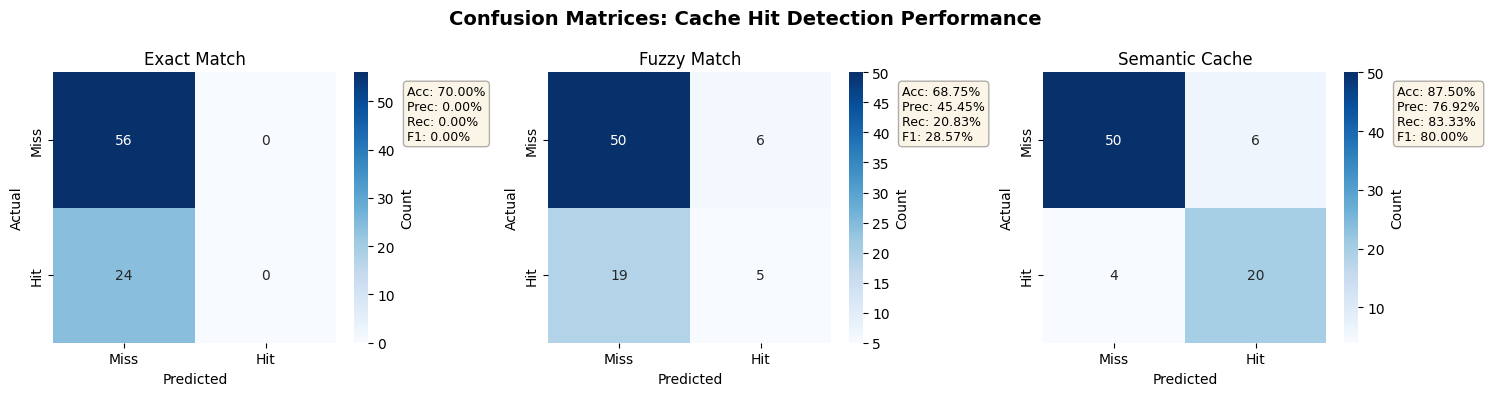


📊 DETAILED PERFORMANCE METRICS

🎯 Exact Match
--------------------------------------------------------------------------------
  True Positives (TP):     0 - Correctly identified cache hits
  True Negatives (TN):    56 - Correctly identified cache misses
  False Positives (FP):    0 - Incorrectly claimed cache hit
  False Negatives (FN):   24 - Missed a valid cache hit

  Accuracy:              70.0% - Overall correctness
  Precision:             0.0% - When it says 'hit', how often is it right?
  Recall (Sensitivity):  0.0% - Of all actual hits, how many did we catch?
  F1 Score:              0.0% - Harmonic mean of precision and recall
  Specificity:           100.0% - Of all actual misses, how many did we correctly identify?


🎯 Fuzzy Match
--------------------------------------------------------------------------------
  True Positives (TP):     5 - Correctly identified cache hits
  True Negatives (TN):    50 - Correctly identified cache misses
  False Positives (FP):    6 - Incor

In [62]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get test queries and their expected labels
test_queries = data.get_test_queries()
y_true = data.test_df['cache_hit'].values  # Ground truth labels

# Generate predictions for each strategy
strategies = [
    ('Exact Match', exact_cache),
    ('Fuzzy Match', fuzzy_cache),
    ('Semantic Cache', semantic_cache)
]

# Store results for comparison
all_predictions = {}
all_metrics = {}

for strategy_name, cache in strategies:
    # Get cache results for all test queries
    cache_results = cache.check_many(test_queries)
    
    # Convert to binary predictions (hit or miss)
    y_pred = np.array([result.hit for result in cache_results])
    
    all_predictions[strategy_name] = y_pred
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Store metrics
    all_metrics[strategy_name] = {
        'confusion_matrix': cm,
        'tn': cm[0, 0],
        'fp': cm[0, 1],
        'fn': cm[1, 0],
        'tp': cm[1, 1]
    }

# Visualize confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('Confusion Matrices: Cache Hit Detection Performance', fontsize=14, fontweight='bold')

for idx, (strategy_name, cache) in enumerate(strategies):
    cm = all_metrics[strategy_name]['confusion_matrix']
    
    # Create heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Miss', 'Hit'],
                yticklabels=['Miss', 'Hit'],
                ax=axes[idx],
                cbar_kws={'label': 'Count'})
    
    axes[idx].set_title(strategy_name)
    axes[idx].set_ylabel('Actual')
    axes[idx].set_xlabel('Predicted')
    
    # Add metrics as text
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    metrics_text = f"Acc: {accuracy:.2%}\nPrec: {precision:.2%}\nRec: {recall:.2%}\nF1: {f1:.2%}"
    axes[idx].text(2.5, 0.5, metrics_text, fontsize=9, 
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.show()

# Print detailed metrics
print("\n" + "="*80)
print("📊 DETAILED PERFORMANCE METRICS")
print("="*80 + "\n")

for strategy_name in ['Exact Match', 'Fuzzy Match', 'Semantic Cache']:
    metrics = all_metrics[strategy_name]
    tn, fp, fn, tp = metrics['tn'], metrics['fp'], metrics['fn'], metrics['tp']
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    print(f"🎯 {strategy_name}")
    print("-" * 80)
    print(f"  True Positives (TP):   {tp:>3} - Correctly identified cache hits")
    print(f"  True Negatives (TN):   {tn:>3} - Correctly identified cache misses")
    print(f"  False Positives (FP):  {fp:>3} - Incorrectly claimed cache hit")
    print(f"  False Negatives (FN):  {fn:>3} - Missed a valid cache hit")
    print()
    print(f"  Accuracy:              {accuracy:.1%} - Overall correctness")
    print(f"  Precision:             {precision:.1%} - When it says 'hit', how often is it right?")
    print(f"  Recall (Sensitivity):  {recall:.1%} - Of all actual hits, how many did we catch?")
    print(f"  F1 Score:              {f1:.1%} - Harmonic mean of precision and recall")
    print(f"  Specificity:           {specificity:.1%} - Of all actual misses, how many did we correctly identify?")
    print("\n")

print("="*80)
print("💡 KEY INSIGHTS")
print("="*80)
print("""
1. EXACT MATCH:
   - Perfect precision (no false positives)
   - Very low recall (misses semantic variations)
   - Best for: Scenarios where false positives are unacceptable

2. FUZZY MATCH:
   - Catches typos and minor variations
   - Moderate recall improvement
   - Best for: User input with potential spelling errors

3. SEMANTIC CACHE:
   - Highest recall (catches semantic variations)
   - May have some false positives
   - Best for: Maximizing cache utilization and understanding intent

Trade-off: Choose based on your application's tolerance for:
  - False Positives: Returning wrong cached answer
  - False Negatives: Missing a cache hit and wasting compute/cost
""")

In [63]:
print("\n📂 Loading data...\n")

faq_df = pd.read_csv(here("data/faq_seed.csv"))
test_df = pd.read_csv(here("data/test_dataset.csv"))

print(f"✅ FAQ entries: {len(faq_df)}")
print(f"✅ Test queries: {len(test_df)}")
print(f"   - Should hit cache: {test_df['cache_hit'].sum()}")
print(f"   - Should miss cache: {(~test_df['cache_hit']).sum()}")


📂 Loading data...

✅ FAQ entries: 8
✅ Test queries: 80
   - Should hit cache: 24
   - Should miss cache: 56


In [64]:
@dataclass
class EvaluationResult:
    """Holds evaluation metrics for a cache configuration."""

    # Core metrics
    true_positives: int = 0
    false_positives: int = 0
    true_negatives: int = 0
    false_negatives: int = 0

    # Details for debugging
    predictions: List[Dict] = field(default_factory=list)

    def get_categorized_predictions(self) -> Dict[str, List[Dict]]:
        """
        Categorize predictions into TP, FP, TN, FN groups.
        
        Returns:
            Dict with keys 'true_positives', 'false_positives', 
            'true_negatives', 'false_negatives', each containing 
            a list of prediction dictionaries.
        """
        categories = {
            'true_positives': [],
            'false_positives': [],
            'true_negatives': [],
            'false_negatives': []
        }
        
        for pred in self.predictions:
            should_hit = pred['should_hit']
            did_hit = pred['did_hit']
            correct_match = pred.get('correct', False)
            
            if should_hit:
                if did_hit and correct_match:
                    categories['true_positives'].append(pred)
                elif did_hit and not correct_match:
                    categories['false_positives'].append(pred)
                else:  # didn't hit
                    categories['false_negatives'].append(pred)
            else:  # should miss
                if did_hit:
                    categories['false_positives'].append(pred)
                else:
                    categories['true_negatives'].append(pred)
        
        return categories

    @property
    def precision(self) -> float:
        """Of all hits, how many were correct?"""
        denom = self.true_positives + self.false_positives
        return self.true_positives / denom if denom > 0 else 0.0

    @property
    def recall(self) -> float:
        """Of all that should hit, how many did?"""
        denom = self.true_positives + self.false_negatives
        return self.true_positives / denom if denom > 0 else 0.0

    @property
    def f1_score(self) -> float:
        """Harmonic mean of precision and recall."""
        if self.precision + self.recall == 0:
            return 0.0
        return 2 * (self.precision * self.recall) / (self.precision + self.recall)

    @property
    def accuracy(self) -> float:
        """Overall accuracy."""
        total = self.true_positives + self.false_positives + \
            self.true_negatives + self.false_negatives
        return (self.true_positives + self.true_negatives) / total if total > 0 else 0.0

    @property
    def hit_rate(self) -> float:
        """What percentage resulted in cache hits?"""
        total = self.true_positives + self.false_positives + \
            self.true_negatives + self.false_negatives
        return (self.true_positives + self.false_positives) / total if total > 0 else 0.0

    def summary(self) -> str:
        return f"""
        Precision: {self.precision:.2%}  (Of hits, how many correct?)
        Recall:    {self.recall:.2%}  (Of should-hits, how many did?)
        F1 Score:  {self.f1_score:.2%}  (Balance of both)
        Accuracy:  {self.accuracy:.2%}  (Overall correctness)
        Hit Rate:  {self.hit_rate:.2%}  (Total cache hits)
        
        Confusion Matrix:
                        Predicted
                    HIT      MISS
        Should HIT  {self.true_positives:4d}     {self.false_negatives:4d}
        Should MISS {self.false_positives:4d}     {self.true_negatives:4d}
        """

In [65]:
class CacheEvaluator:
    """Evaluates semantic cache performance against labeled data."""

    def __init__(self, faq_df: pd.DataFrame, test_df: pd.DataFrame):
        self.faq_df = faq_df
        self.test_df = test_df

        # Build lookup for expected answers
        self.question_to_idx = {
            q: i for i, q in enumerate(faq_df["question"])
        }

    def _get_expected_match(self, row) -> Optional[str]:
        """Get the expected cache match for a test query."""
        if not row["cache_hit"]:
            return None  # Should miss

        src_id = row["src_question_id"]
        return self.faq_df.iloc[src_id]["question"]

    def evaluate(
        self,
        cache_check_fn: Callable[[str], Optional[Dict]],
        verbose: bool = False
    ) -> EvaluationResult:
        """
        Evaluate a cache implementation.

        Args:
            cache_check_fn: Function that takes query, returns match dict or None
            verbose: Print detailed results

        Returns:
            EvaluationResult with metrics
        """
        result = EvaluationResult()

        for _, row in self.test_df.iterrows():
            query = row["question"]
            should_hit = row["cache_hit"]
            expected_match = self._get_expected_match(row)

            # Check the cache
            cache_result = cache_check_fn(query)
            did_hit = cache_result is not None

            # Determine if hit was correct
            if did_hit:
                actual_match = cache_result.get("matched_question", "")
                # Check if matched the right question
                correct_match = (
                    expected_match is not None and
                    actual_match == expected_match
                )
            else:
                actual_match = None
                correct_match = False

            # Update counts
            if should_hit:
                if did_hit and correct_match:
                    result.true_positives += 1
                elif did_hit and not correct_match:
                    result.false_positives += 1  # Hit wrong answer!
                else:
                    result.false_negatives += 1
            else:  # Should miss
                if did_hit:
                    result.false_positives += 1
                else:
                    result.true_negatives += 1

            # Store for debugging
            result.predictions.append({
                "query": query,
                "should_hit": should_hit,
                "did_hit": did_hit,
                "expected": expected_match,
                "actual": actual_match,
                "correct": (did_hit == should_hit) and (not did_hit or correct_match)
            })

        if verbose:
            print("\n📋 Detailed Results:")
            for p in result.predictions:
                status = "✅" if p["correct"] else "❌"
                print(f"{status} '{p['query'][:40]}'")
                if not p["correct"]:
                    print(f"   Expected: {p['expected']}")
                    print(f"   Got: {p['actual']}")

        return result


In [66]:
@dataclass
class CacheEntry:
    question: str
    answer: str
    embedding: np.ndarray


class EvaluatableCache:
    """Semantic cache with evaluation-friendly interface."""

    def __init__(self, encoder, distance_threshold: float = 0.3):
        self.encoder = encoder
        self.distance_threshold = distance_threshold
        self.entries: List[CacheEntry] = []
        self._embedding_matrix: Optional[np.ndarray] = None

    def add_many(self, qa_pairs: List[Tuple[str, str]]) -> None:
        questions = [q for q, _ in qa_pairs]
        embeddings = self.encoder.encode(questions, show_progress_bar=False)

        for (question, answer), embedding in zip(qa_pairs, embeddings):
            self.entries.append(CacheEntry(question, answer, embedding))

        self._embedding_matrix = None

    def _get_embedding_matrix(self) -> np.ndarray:
        if self._embedding_matrix is None:
            self._embedding_matrix = np.array(
                [e.embedding for e in self.entries])
        return self._embedding_matrix

    def check(self, query: str, threshold_override: float = None) -> Optional[Dict]:
        """Check cache with optional threshold override."""
        if not self.entries:
            return None

        threshold = threshold_override if threshold_override is not None else self.distance_threshold

        query_embedding = self.encoder.encode(
            [query], show_progress_bar=False)[0]
        embeddings = self._get_embedding_matrix()

        # Vectorized cosine distance
        dot_products = np.dot(embeddings, query_embedding)
        norms = np.linalg.norm(embeddings, axis=1) * \
            np.linalg.norm(query_embedding)
        distances = 1 - (dot_products / norms)

        best_idx = np.argmin(distances)
        best_distance = distances[best_idx]

        if best_distance <= threshold:
            return {
                "matched_question": self.entries[best_idx].question,
                "answer": self.entries[best_idx].answer,
                "distance": float(best_distance)
            }

        return None

    def get_all_distances(self, query: str) -> List[Tuple[str, float]]:
        """Get distances to all entries (for analysis)."""
        query_embedding = self.encoder.encode(
            [query], show_progress_bar=False)[0]
        embeddings = self._get_embedding_matrix()

        dot_products = np.dot(embeddings, query_embedding)
        norms = np.linalg.norm(embeddings, axis=1) * \
            np.linalg.norm(query_embedding)
        distances = 1 - (dot_products / norms)

        return [(self.entries[i].question, distances[i]) for i in range(len(self.entries))]



In [67]:
# Create cache and evaluator
cache = EvaluatableCache(encoder, distance_threshold=0.36)
qa_pairs = list(zip(faq_df["question"], faq_df["answer"]))
cache.add_many(qa_pairs)

evaluator = CacheEvaluator(faq_df, test_df)

print("✅ Cache and evaluator ready!\n")

result = evaluator.evaluate(cache.check)
print(result.summary())

✅ Cache and evaluator ready!


        Precision: 90.00%  (Of hits, how many correct?)
        Recall:    75.00%  (Of should-hits, how many did?)
        F1 Score:  81.82%  (Balance of both)
        Accuracy:  90.00%  (Overall correctness)
        Hit Rate:  25.00%  (Total cache hits)

        Confusion Matrix:
                        Predicted
                    HIT      MISS
        Should HIT    18        6
        Should MISS    2       54
        


In [68]:
categories = result.get_categorized_predictions()

print("\n📊 True Positives (Correctly hit cache):")
for pred in categories['true_positives'][:5]:  # Show first 5
    print(f"  ✅ Query: '{pred['query']}'")
    print(f"     Matched: '{pred['actual']}'")

print(f"\n❌ False Positives (Hit cache when shouldn't or wrong match):")
for pred in categories['false_positives']:
    print(f"  Query: '{pred['query']}'")
    print(f"     Expected: {pred['expected']}")
    print(f"     Got: '{pred['actual']}'")

print(f"\n📊 False Negatives (Should have hit but didn't):")
for pred in categories['false_negatives']:
    print(f"  Query: '{pred['query']}'")
    print(f"     Should have matched: '{pred['expected']}'")

print(f"\n✅ True Negatives (Correctly missed cache): {len(categories['true_negatives'])} cases")


📊 True Positives (Correctly hit cache):
  ✅ Query: 'What's the process for getting my money back?'
     Matched: 'How do I get a refund?'
  ✅ Query: 'How can I request a refund for my purchase?'
     Matched: 'How do I get a refund?'
  ✅ Query: 'What steps do I follow to return an item for money back?'
     Matched: 'How do I get a refund?'
  ✅ Query: 'How do I recover my forgotten password?'
     Matched: 'Can I reset my password?'
  ✅ Query: 'I forgot my password, how can I get back into my account?'
     Matched: 'Can I reset my password?'

❌ False Positives (Hit cache when shouldn't or wrong match):
  Query: 'How do I upgrade my subscription plan?'
     Expected: None
     Got: 'How do I cancel my subscription?'
  Query: 'Can I pause my subscription temporarily?'
     Expected: None
     Got: 'How do I cancel my subscription?'

📊 False Negatives (Should have hit but didn't):
  Query: 'What's the process to reset my login credentials?'
     Should have matched: 'Can I reset my pass

<div style="
  background-color:#140A0A;
  border-left:5px solid #EF4444;
  padding:16px;
  border-radius:10px;
">

<span style="
  background:#2B1212;
  color:#F87171;
  padding:4px 10px;
  border-radius:999px;
  font-size:12px;
  font-weight:600;
">
LATENCY · BOTTLENECKS · FAILURES
</span>

## 🔴 **PART 3: Cache Optimization**

1. Finding the right threshold  
2. Comparing different Embedding Models

</div>


### **Finding the Right Threshold**

In [69]:
# Test different thresholds
thresholds = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
threshold_results = []

print(f"{'Threshold':<12} {'Precision':<12} {'Recall':<12} {'F1':<12} {'Accuracy':<12}")
print("-" * 60)

for threshold in thresholds:
    def check_fn(q, t=threshold): return cache.check(q, threshold_override=t)
    result = evaluator.evaluate(check_fn)

    threshold_results.append({
        "threshold": threshold,
        "precision": result.precision,
        "recall": result.recall,
        "f1": result.f1_score,
        "accuracy": result.accuracy,
        "hit_rate": result.hit_rate
    })

    print(f"{threshold:<12.2f} {result.precision:<12.2%} {result.recall:<12.2%} "
          f"{result.f1_score:<12.2%} {result.accuracy:<12.2%}")

# Find best threshold
best_by_f1 = max(threshold_results, key=lambda x: x["f1"])
best_by_precision = max(threshold_results, key=lambda x: x["precision"])

print(
    f"\n💡 Best threshold by F1: {best_by_f1['threshold']} (F1={best_by_f1['f1']:.2%})")
print(
    f"💡 Best threshold by Precision: {best_by_precision['threshold']} (Precision={best_by_precision['precision']:.2%})")

Threshold    Precision    Recall       F1           Accuracy    
------------------------------------------------------------
0.10         100.00%      8.33%        15.38%       72.50%      
0.15         100.00%      16.67%       28.57%       75.00%      
0.20         100.00%      37.50%       54.55%       81.25%      
0.25         100.00%      45.83%       62.86%       83.75%      
0.30         100.00%      66.67%       80.00%       90.00%      
0.35         90.00%       75.00%       81.82%       90.00%      
0.40         79.17%       82.61%       80.85%       88.75%      
0.45         75.00%       91.30%       82.35%       88.75%      
0.50         68.75%       95.65%       80.00%       86.25%      

💡 Best threshold by F1: 0.45 (F1=82.35%)
💡 Best threshold by Precision: 0.1 (Precision=100.00%)


In [70]:
best_by_f1

{'threshold': 0.45,
 'precision': 0.75,
 'recall': 0.9130434782608695,
 'f1': 0.8235294117647057,
 'accuracy': 0.8875,
 'hit_rate': 0.35}

### **Visualize Performance for Each Threshold**


📈 Creating threshold visualization...

✅ Saved: visualizations/threshold_analysis.png


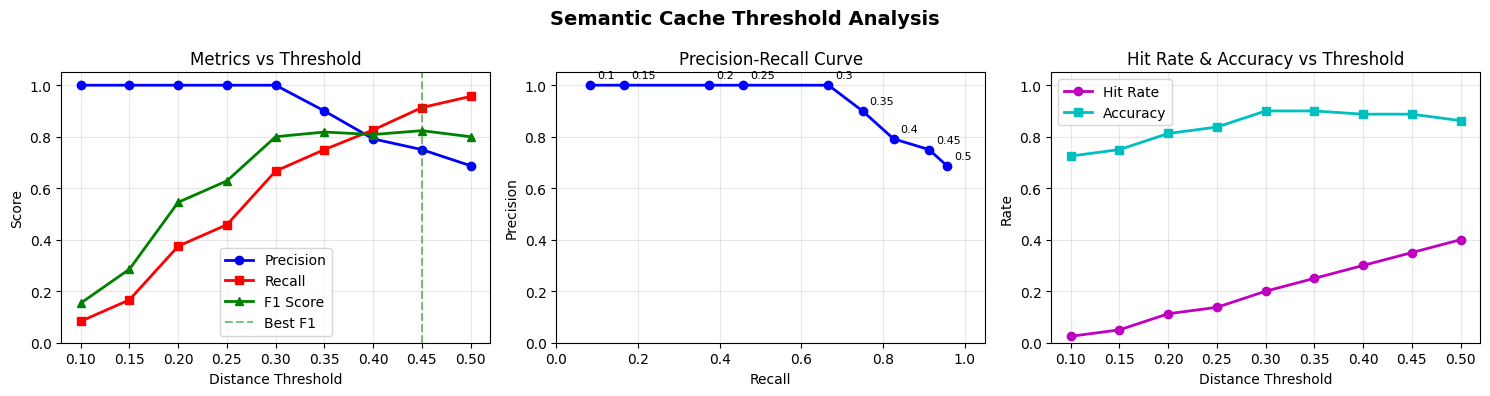

In [71]:
print("\n📈 Creating threshold visualization...\n")

# Create visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle("Semantic Cache Threshold Analysis",
             fontsize=14, fontweight='bold')

# Plot 1: Precision vs Recall
ax1 = axes[0]
tholds = [r["threshold"] for r in threshold_results]
precisions = [r["precision"] for r in threshold_results]
recalls = [r["recall"] for r in threshold_results]
f1s = [r["f1"] for r in threshold_results]

ax1.plot(tholds, precisions, 'b-o', label='Precision', linewidth=2)
ax1.plot(tholds, recalls, 'r-s', label='Recall', linewidth=2)
ax1.plot(tholds, f1s, 'g-^', label='F1 Score', linewidth=2)
ax1.axvline(x=best_by_f1["threshold"], color='g',
            linestyle='--', alpha=0.5, label='Best F1')
ax1.set_xlabel("Distance Threshold")
ax1.set_ylabel("Score")
ax1.set_title("Metrics vs Threshold")
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 1.05)

# Plot 2: Precision-Recall Curve
ax2 = axes[1]
ax2.plot(recalls, precisions, 'b-o', linewidth=2)
for i, t in enumerate(tholds):
    ax2.annotate(f'{t}', (recalls[i], precisions[i]),
                 textcoords="offset points", xytext=(5, 5), fontsize=8)
ax2.set_xlabel("Recall")
ax2.set_ylabel("Precision")
ax2.set_title("Precision-Recall Curve")
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, 1.05)
ax2.set_ylim(0, 1.05)

# Plot 3: Hit Rate vs Accuracy
ax3 = axes[2]
hit_rates = [r["hit_rate"] for r in threshold_results]
accuracies = [r["accuracy"] for r in threshold_results]

ax3.plot(tholds, hit_rates, 'm-o', label='Hit Rate', linewidth=2)
ax3.plot(tholds, accuracies, 'c-s', label='Accuracy', linewidth=2)
ax3.set_xlabel("Distance Threshold")
ax3.set_ylabel("Rate")
ax3.set_title("Hit Rate & Accuracy vs Threshold")
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_ylim(0, 1.05)

plt.tight_layout()
plt.savefig(here("visualizations/threshold_analysis.png"),
            dpi=150, bbox_inches='tight')
# plt.close()

print("✅ Saved: visualizations/threshold_analysis.png")

### **Comparing Different Embedding Models**

In [72]:
# Compare models
models_to_compare = [
    ("all-MiniLM-L6-v2", "MiniLM (fast)"),
    ("all-mpnet-base-v2", "MPNet (balanced)"),  # Uncomment to test more
]

model_results = []

print("\n📊 Model Comparison (threshold=0.45):\n")
print(f"{'Model':<25} {'F1':<10} {'Precision':<12} {'Recall':<12} {'Time':<10}")
print("-" * 70)

for model_name, display_name in models_to_compare:
    start = time.time()

    # Load model and create cache
    model = SentenceTransformer(model_name)
    model_cache = EvaluatableCache(model, distance_threshold=0.45)
    model_cache.add_many(qa_pairs)

    # Evaluate
    result = evaluator.evaluate(model_cache.check)
    elapsed = time.time() - start

    model_results.append({
        "model": display_name,
        "f1": result.f1_score,
        "precision": result.precision,
        "recall": result.recall,
        "time": elapsed
    })

    print(f"{display_name:<25} {result.f1_score:<10.2%} {result.precision:<12.2%} "
          f"{result.recall:<12.2%} {elapsed:<1f}s")


📊 Model Comparison (threshold=0.45):

Model                     F1         Precision    Recall       Time      
----------------------------------------------------------------------
MiniLM (fast)             70.18%     57.14%       90.91%       2.274857s
MPNet (balanced)          82.35%     75.00%       91.30%       2.934325s


### **Run evaluation with optimal threshold and collect errors**

In [ ]:
# Run evaluation with optimal threshold and collect errors
best_threshold = best_by_f1["threshold"]
def check_fn(q): return cache.check(q, threshold_override=best_threshold)


result = evaluator.evaluate(check_fn, verbose=False)

# Analyze errors
false_positives = [
    p for p in result.predictions if not p["correct"] and p["did_hit"]]
false_negatives = [p for p in result.predictions if not p["correct"]
                   and not p["did_hit"] and p["should_hit"]]

print(
    f"\n❌ False Positives ({len(false_positives)} cases) - Cache returned wrong answer:")
print("-" * 60)
for fp in false_positives[:3]:  # Show top 3
    print(f"Query: '{fp['query']}'")
    print(f"  Got: '{fp['actual']}'")
    print(
        f"  Expected: {'(should miss)' if fp['expected'] is None else fp['expected']}")
    print()

print(
    f"\n❌ False Negatives ({len(false_negatives)} cases) - Cache missed when it shouldn't:")
print("-" * 60)
for fn in false_negatives[:3]:  # Show top 3
    print(f"Query: '{fn['query']}'")
    print(f"  Expected match: '{fn['expected']}'")

    # Show how close it was
    distances = cache.get_all_distances(fn['query'])
    distances.sort(key=lambda x: x[1])
    closest = distances[0]
    print(f"  Closest match: '{closest[0][:50]}' (distance: {closest[1]:.4f})")
    print()

<div style="
  background-color:#071A12;
  border-left:5px solid #10B981;
  padding:16px;
  border-radius:10px;
">

<span style="
  background:#0F2E22;
  color:#34D399;
  padding:4px 10px;
  border-radius:999px;
  font-size:12px;
  font-weight:600;
">
SPEED · COST · RELIABILITY
</span>

## 🟢 **PART 4: Reranking**
 
1. Reranking Strategies
    - Simple Keyword Reranker
    - CrossEncoder
    - LLM Reranker
2. Evaluation (speed | accuracy | cost)

(Different threshold + not optimized)
</div>

In [73]:
class RerankedCache:
    """Cache with two-stage retrieval: embedding + reranking."""

    def __init__(self, cache: EvaluatableCache, reranker_fn: Callable):
        self.cache = cache
        self.reranker_fn = reranker_fn

    def check(self, query: str, top_k: int = 5, threshold: float = 0.3) -> Optional[Dict]:
        """
        Two-stage retrieval:
        1. Get top-K candidates by embedding similarity
        2. Rerank candidates using reranker function
        """
        # Stage 1: Get top-K candidates
        query_embedding = self.cache.encoder.encode(
            [query], show_progress_bar=False)[0]
        embeddings = self.cache._get_embedding_matrix()

        dot_products = np.dot(embeddings, query_embedding)
        norms = np.linalg.norm(embeddings, axis=1) * \
            np.linalg.norm(query_embedding)
        distances = 1 - (dot_products / norms)

        # Get top-K indices
        top_k_indices = np.argsort(distances)[:top_k]

        candidates = [
            {
                "question": self.cache.entries[i].question,
                "answer": self.cache.entries[i].answer,
                "distance": float(distances[i])
            }
            for i in top_k_indices
            if distances[i] <= threshold * 2  # Loose threshold for candidates
        ]

        if not candidates:
            return None

        # Stage 2: Rerank
        reranked = self.reranker_fn(query, candidates)
        # print(reranked)
        if reranked and reranked[0]["final_score"] > 0.5:
            best = reranked[0]
            
            return {
                "matched_question": best["question"],
                "answer": best["answer"],
                "distance": best["distance"],
                "reranked_score": best["final_score"]
            }
        return None

In [107]:
# Simple reranker example (in practice, use a cross-encoder model)
def simple_keyword_reranker(query: str, candidates: List[Dict]) -> List[Dict]:
    """
    Simple reranker that boosts candidates with keyword overlap.
    (In production, use a cross-encoder model instead!)
    """
    query_words = set(query.lower().split())

    for candidate in candidates:
        candidate_words = set(candidate["question"].lower().split())
        overlap = len(query_words & candidate_words)
        # Combine embedding distance with keyword overlap
        candidate["final_score"] = (
            1 - candidate["distance"]) + (overlap * 0.1)

    return sorted(candidates, key=lambda x: x["final_score"], reverse=True)

In [108]:
print("\n📊 Demonstrating reranking on example queries:\n")

reranked_cache = RerankedCache(cache, simple_keyword_reranker)

demo_queries = [
    "I need my money back please",
    "how do I get a refund for my order",
]

for query in demo_queries:
    result = reranked_cache.check(query)
    if result:
        print(f"Query: '{query}'")
        print(f"  Match: '{result['matched_question']}'")
        print(f"  Embedding distance: {result['distance']:.4f}")
        print(f"  Reranked score: {result['reranked_score']:.4f}")
        print()


📊 Demonstrating reranking on example queries:

Query: 'I need my money back please'
  Match: 'How do I get a refund?'
  Embedding distance: 0.3656
  Reranked score: 0.7344

Query: 'how do I get a refund for my order'
  Match: 'How do I get a refund?'
  Embedding distance: 0.1304
  Reranked score: 1.3696



### **Cross Encoder Reranking**

In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List

import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Set up plotting style
plt.style.use("default")
sns.set_palette("husl")

print("📦 Libraries and evaluation utilities imported successfully")

📦 Libraries and evaluation utilities imported successfully


In [116]:
class CrossEncoder:
    def __init__(self, model_name_or_path="Alibaba-NLP/gte-reranker-modernbert-base"):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
        model = AutoModelForSequenceClassification.from_pretrained(
            model_name_or_path,
            torch_dtype=torch.float16,
        )
        self.model = model.eval()

    def pair_distance(self, query: str, context: str) -> float:
        return 1 - self.predict([query], [context])[0]

    def predict(self, queries: List[str], contexts: List[str]) -> List[float]:
        """
        Direct cross encoder prediction for query-context pairs.

        Args:
            queries: List of query strings
            contexts: List of context strings (same length as queries)

        Returns:
            List of similarity scores [0.0-1.0] for each query-context pair
        """
        pairs = list(zip(queries, contexts))
        inputs = self.tokenizer(
            pairs,
            padding=True,
            truncation=True,
            return_tensors="pt",
            max_length=512,
        )
        with torch.no_grad():
            outputs = self.model(**inputs, return_dict=True).logits.view(-1).float()
        probs = torch.sigmoid(outputs).numpy()
        return probs.tolist()

    def create_reranker(self):
        return CrossEncoderReranker(self)


class CrossEncoderReranker:
    def __init__(self, cross_encoder: CrossEncoder):
        self.cross_encoder = cross_encoder

    def __call__(self, query: str, candidates: List[Dict]) -> List[Dict]:
        """
        Cross encoder reranker function for semantic cache integration.

        Args:
            query: The search query
            candidates: List of cache candidate dictionaries

        Returns:
            Filtered and reordered candidates with cross encoder metadata
        """
        if not candidates:
            return []

        # Extract prompts for cross encoder scoring
        prompts = [c.get("prompt", "") for c in candidates]

        # Get cross encoder scores
        scores = self.cross_encoder.predict([query] * len(prompts), prompts)

        # Create scored candidates with metadata using dict comprehension
        validated_candidates = [
            (
                {
                    **candidate,
                    "reranker_type": "cross_encoder",
                    "reranker_score": float(score),
                    "reranker_distance": 1 - float(score),
                },
                score,
            )
            for candidate, score in zip(candidates, scores)
        ]
        # Sort by cross encoder score (highest first)
        validated_candidates.sort(key=lambda x: x[1], reverse=True)

        # Return just the enriched candidates
        return [candidate for candidate, _ in validated_candidates]

In [117]:
cross_encoder = CrossEncoder("Alibaba-NLP/gte-reranker-modernbert-base")

In [118]:
cross_encoder.predict(
    [
        "what is the capital of China?",
        "how to implement quick sort in python?",
        "how to implement quick sort in python?",
    ],
    ["Beijing", "Introduction of quick sort", "The weather is nice today"],
)

[0.873214840888977, 0.9133679866790771, 0.23353151977062225]

### **LLM Reranker**

In [119]:
from dotenv import load_dotenv
import os
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import Runnable
from langchain_core.language_models import BaseChatModel
from tqdm import tqdm
import math
load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

In [139]:
class SimilarityResult(BaseModel):
    reason: str = Field(
        description="Explanation of why the answer was True or False")
    is_similar: bool = Field(
        description="True if the sentences mean the same thing, False otherwise"
    )

@dataclass(frozen=True)
class LLMEvaluationResult:
    resulting_items: List[SimilarityResult]

    @property
    def df(self):
        return pd.DataFrame([dict(it) for it in self.resulting_items])

def batch_iterable(iterable, batch_size):
    for i in range(0, len(iterable), batch_size):
        yield iterable[i: i + batch_size]

DEFAULT_COMPARE_PROMPT_TEMPLATE = """
You are a helpful assistant that determines if two sentences mean the same thing.
You will be given two sentences and you will need to determine if they mean the same thing.
You will need to return a JSON object with the following fields:
- is_similar: True if the sentences mean the same thing, False otherwise
- reason: Explanation of why the answer was True or False
The two sentences are:
- sentence1: {sentence1}
- sentence2: {sentence2}
"""

class LLMEvaluator:
    @staticmethod
    def construct_with_gpt(
        prompt=DEFAULT_COMPARE_PROMPT_TEMPLATE, model="gpt-4o-mini"
    ):
        llm = ChatOpenAI(model=model).with_structured_output(SimilarityResult)
        return LLMEvaluator(llm, prompt)

    def __init__(self, llm: BaseChatModel, prompt: str):
        prompt = PromptTemplate(
            template=prompt,
            input_variables=["sentence1", "sentence2"],
        )
        # IMPORTANT: do NOT bind tools when using structured output
        self.prompt = prompt
        self.chain: Runnable = prompt | llm

    def predict(
        self,
        dataset: List[Tuple[str, str]],
        batch_size: int,
        show_progress: bool = True,
    ) -> LLMEvaluationResult:
        all_results = []
        dataset = list(dataset)
        num_batches = math.ceil(len(dataset) / batch_size)

        for batch in tqdm(
            batch_iterable(dataset, batch_size),
            total=num_batches,
            disable=not show_progress,
        ):
            batch_payload = [{"sentence1": s1, "sentence2": s2}
                             for s1, s2 in batch]
            try:
                batch_results = self.chain.batch(batch_payload)
                # Ensure we have a list of SimilarityResult (some providers may return dicts)
                for r in batch_results:
                    if isinstance(r, SimilarityResult):
                        all_results.append(r)
                    else:
                        all_results.append(SimilarityResult.model_validate(r))
            except Exception as e:
                print(f"Error in batch: {e}")
                # Optional: append a default negative result instead of raising
                for _ in batch_payload:
                    all_results.append(SimilarityResult(
                        is_similar=False, reason=str(e)))

        return LLMEvaluationResult(all_results)

    def create_reranker(self, batch_size: int = 5) -> "LLMReranker":
        return LLMReranker(self, batch_size=batch_size)


class LLMReranker:
    def __init__(self, llm_evaluator: LLMEvaluator, batch_size: int = 5):
        self.llm_evaluator = llm_evaluator
        self.batch_size = batch_size

    def __call__(self, query: str, candidates: List[Dict]):
        if not candidates:
            return []

        # Prepare query-prompt pairs for LLM validation
        validation_pairs = []
        for candidate in candidates:
            prompt = candidate.get("prompt", "")
            validation_pairs.append((query, prompt))

        # Get LLM validation results
        llm_result = self.llm_evaluator.predict(
            validation_pairs, batch_size=self.batch_size, show_progress=False
        )

        # Filter and enrich candidates based on LLM validation
        validated_candidates = [
            {
                **candidate,
                "reranker_type": "llm",
                "reranker_score": 1.0 if validation.is_similar else 0.0,
                "reranker_distance": 0.0 if validation.is_similar else 1.0,
                "reranker_reason": validation.reason,
            }
            for candidate, validation in zip(candidates, llm_result.resulting_items)
            if validation.is_similar
        ]
        return validated_candidates

In [140]:
# Create adapter wrappers that normalize the reranker interfaces

def simple_keyword_reranker_adapter(query: str, candidates: List[Dict]) -> List[Dict]:
    """
    Adapter for simple_keyword_reranker.
    Converts 'question' key to match what simple_keyword_reranker expects.
    """
    if not candidates:
        return []
    
    # simple_keyword_reranker expects 'question' key (which we already have)
    reranked = simple_keyword_reranker(query, candidates)
    
    # Normalize the output: ensure 'final_score' exists
    for candidate in reranked:
        if 'final_score' not in candidate:
            candidate['final_score'] = 1 - candidate.get('distance', 1.0)
    
    return reranked


def cross_encoder_reranker_adapter(cross_encoder_reranker: CrossEncoderReranker):
    """
    Adapter for CrossEncoderReranker.
    Converts 'question' to 'prompt' and adds 'final_score'.
    """
    def adapter(query: str, candidates: List[Dict]) -> List[Dict]:
        if not candidates:
            return []
        
        # Convert 'question' to 'prompt' for cross encoder
        adapted_candidates = []
        for c in candidates:
            adapted = c.copy()
            adapted['prompt'] = c.get('question', '')
            adapted_candidates.append(adapted)
        
        # Call cross encoder
        reranked = cross_encoder_reranker(query, adapted_candidates)
        
        # Normalize output: add 'final_score' from 'reranker_score'
        for candidate in reranked:
            candidate['final_score'] = candidate.get('reranker_score', 0.0)
            # Keep 'question' key for consistency
            if 'prompt' in candidate and 'question' not in candidate:
                candidate['question'] = candidate['prompt']
        
        return reranked
    
    return adapter


def llm_reranker_adapter(llm_reranker: LLMReranker):
    """
    Adapter for LLMReranker.
    Converts 'question' to 'prompt' and adds 'final_score'.
    """
    def adapter(query: str, candidates: List[Dict]) -> List[Dict]:
        if not candidates:
            return []
        
        # Convert 'question' to 'prompt' for LLM
        adapted_candidates = []
        for c in candidates:
            adapted = c.copy()
            adapted['prompt'] = c.get('question', '')
            adapted_candidates.append(adapted)
        
        # Call LLM reranker
        reranked = llm_reranker(query, adapted_candidates)
        
        # Normalize output: add 'final_score' from 'reranker_score'
        for candidate in reranked:
            candidate['final_score'] = candidate.get('reranker_score', 0.0)
            # Keep 'question' key for consistency
            if 'prompt' in candidate and 'question' not in candidate:
                candidate['question'] = candidate['prompt']
        
        return reranked
    
    return adapter


print("✅ Reranker adapters created")

✅ Reranker adapters created


In [141]:
print("\n🔧 Initializing rerankers...\n")

# 1. Cross-encoder reranker
print("Loading cross-encoder model...")
cross_encoder_model = CrossEncoder("Alibaba-NLP/gte-reranker-modernbert-base")
cross_encoder_reranker = cross_encoder_model.create_reranker()
cross_encoder_adapter = cross_encoder_reranker_adapter(cross_encoder_reranker)
print("✅ Cross-encoder ready")

# 2. LLM reranker
print("\nInitializing LLM reranker...")
llm_evaluator = LLMEvaluator.construct_with_gpt(
    prompt=DEFAULT_COMPARE_PROMPT_TEMPLATE,
    model="gpt-4o-mini"
)
llm_reranker = llm_evaluator.create_reranker(batch_size=10)
llm_adapter = llm_reranker_adapter(llm_reranker)
print("✅ LLM reranker ready")

print("\n✅ All rerankers initialized!")


🔧 Initializing rerankers...

Loading cross-encoder model...
✅ Cross-encoder ready

Initializing LLM reranker...
✅ LLM reranker ready

✅ All rerankers initialized!


### **Creating caches with different reranking strategies**

In [142]:
print("\n🏗️  Creating caches with different reranking strategies...\n")

# 1. Baseline - no reranking
baseline_cache = cache
print("✅ Baseline cache (no reranking)")

# 2. Simple keyword reranker
simple_reranked = RerankedCache(cache, simple_keyword_reranker_adapter)
print("✅ Simple keyword reranked cache")

# 3. Cross-encoder reranker
cross_reranked = RerankedCache(cache, cross_encoder_adapter)
print("✅ Cross-encoder reranked cache")

# 4. LLM reranker
llm_reranked = RerankedCache(cache, llm_adapter)
print("✅ LLM reranked cache")

print("\n✅ All caches created!")


🏗️  Creating caches with different reranking strategies...

✅ Baseline cache (no reranking)
✅ Simple keyword reranked cache
✅ Cross-encoder reranked cache
✅ LLM reranked cache

✅ All caches created!


### **Reranking Strategy Evaluation**

In [145]:
print("\n⚡ RERANKING STRATEGY EVALUATION\n")
print("="*90)

# Define strategies
reranking_strategies = [
    ("Baseline (No Reranking)", baseline_cache),
    ("Simple Keyword", simple_reranked),
    ("Cross-Encoder", cross_reranked),
    ("LLM (GPT-4o-mini)", llm_reranked)
]

reranking_results = {}

for strategy_name, cache_instance in reranking_strategies:
    print(f"\n🔄 Evaluating {strategy_name}...")
    
    start_time = time.time()
    result = evaluator.evaluate(cache_instance.check)
    elapsed = time.time() - start_time
    
    reranking_results[strategy_name] = {
        'precision': result.precision,
        'recall': result.recall,
        'f1': result.f1_score,
        'accuracy': result.accuracy,
        'hit_rate': result.hit_rate,
        'time': elapsed,
        'result': result
    }
    
    print(f"   ✅ Precision: {result.precision:.1%}, Recall: {result.recall:.1%}, "
          f"F1: {result.f1_score:.1%}, Time: {elapsed:.2f}s")

print("\n" + "="*90)
print("📊 Evaluation complete!")


⚡ RERANKING STRATEGY EVALUATION


🔄 Evaluating Baseline (No Reranking)...
   ✅ Precision: 90.0%, Recall: 75.0%, F1: 81.8%, Time: 0.88s

🔄 Evaluating Simple Keyword...
   ✅ Precision: 53.8%, Recall: 100.0%, F1: 70.0%, Time: 0.67s

🔄 Evaluating Cross-Encoder...
   ✅ Precision: 52.3%, Recall: 100.0%, F1: 68.7%, Time: 5.54s

🔄 Evaluating LLM (GPT-4o-mini)...
   ✅ Precision: 100.0%, Recall: 54.2%, F1: 70.3%, Time: 61.05s

📊 Evaluation complete!


In [146]:
# Print results summary table
print("\n📊 RERANKING STRATEGY COMPARISON\n")
print(f"{'Strategy':<25} {'Precision':<12} {'Recall':<12} {'F1 Score':<12} {'Accuracy':<12} {'Time(s)'}")
print("="*90)

for strategy_name, _ in reranking_strategies:
    r = reranking_results[strategy_name]
    print(f"{strategy_name:<25} {r['precision']:<12.1%} {r['recall']:<12.1%} "
          f"{r['f1']:<12.1%} {r['accuracy']:<12.1%} {r['time']:<8.2f}")

print("\n" + "="*90)


📊 RERANKING STRATEGY COMPARISON

Strategy                  Precision    Recall       F1 Score     Accuracy     Time(s)
Baseline (No Reranking)   90.0%        75.0%        81.8%        90.0%        0.88    
Simple Keyword            53.8%        100.0%       70.0%        77.5%        0.67    
Cross-Encoder             52.3%        100.0%       68.7%        73.8%        5.54    
LLM (GPT-4o-mini)         100.0%       54.2%        70.3%        86.2%        61.05   



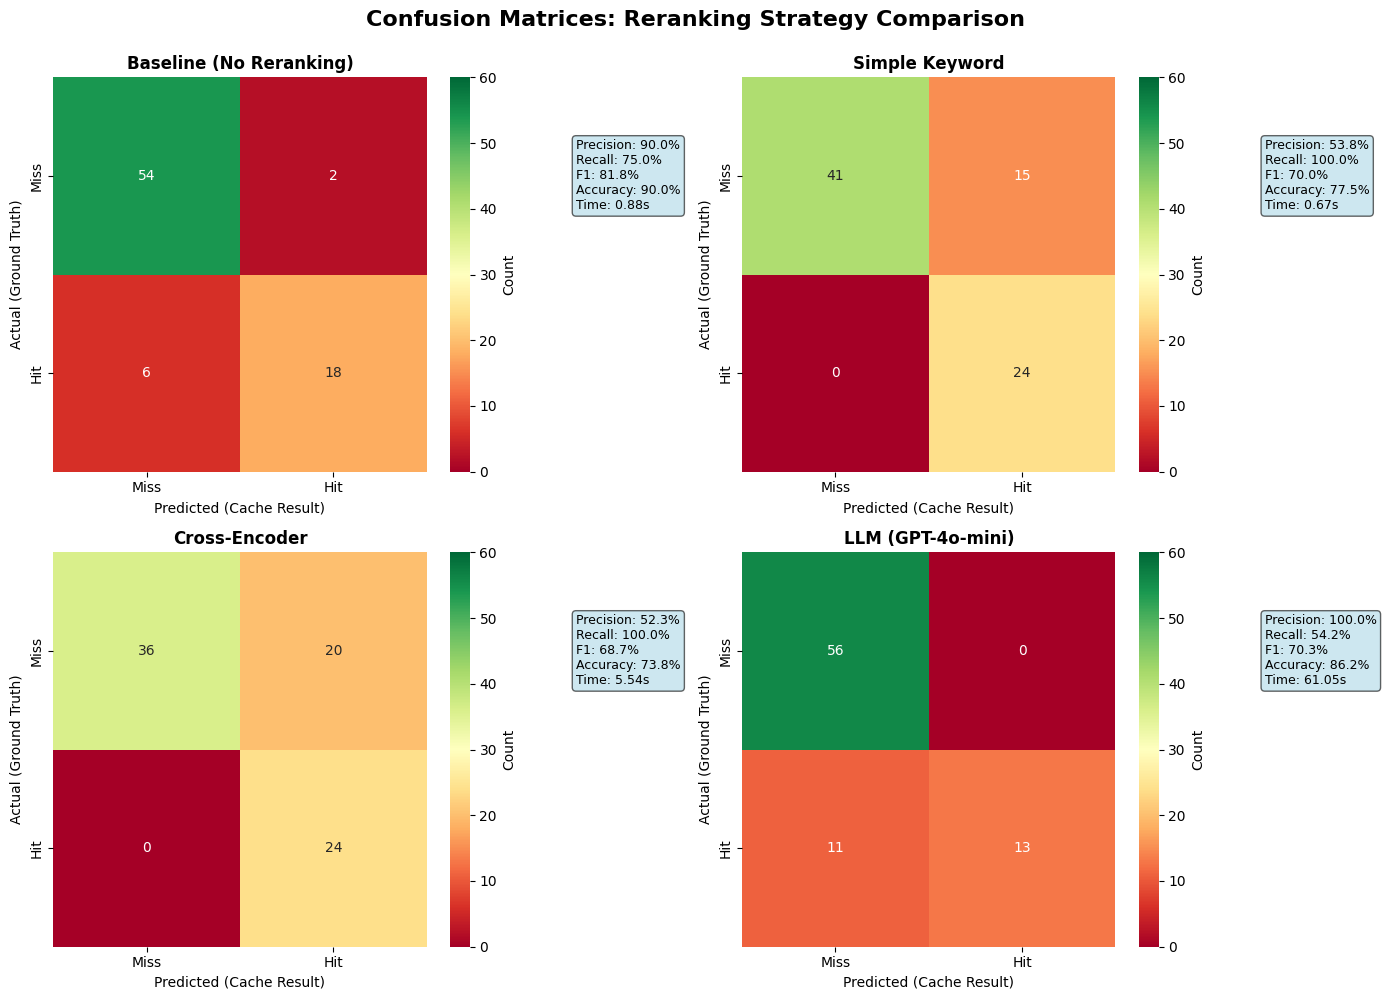


📊 Confusion Matrix Key:
  - Top-Left (TN): Correctly identified cache misses
  - Top-Right (FP): Incorrectly returned cached result (FALSE POSITIVE)
  - Bottom-Left (FN): Missed a valid cache hit (FALSE NEGATIVE)
  - Bottom-Right (TP): Correctly identified cache hits


In [151]:
# Create confusion matrices
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Confusion Matrices: Reranking Strategy Comparison', 
             fontsize=16, fontweight='bold', y=0.995)
axes = axes.flatten()

for idx, (strategy_name, _) in enumerate(reranking_strategies):
    result = reranking_results[strategy_name]['result']
    
    # Extract predictions
    y_true = []
    y_pred = []
    
    for pred in result.predictions:
        y_true.append(pred['should_hit'])
        y_pred.append(pred['did_hit'])
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn',
                xticklabels=['Miss', 'Hit'],
                yticklabels=['Miss', 'Hit'],
                ax=axes[idx],
                cbar_kws={'label': 'Count'},
                vmin=0, vmax=max(60, cm.max()))
    
    axes[idx].set_title(f"{strategy_name}", fontweight='bold', fontsize=12)
    axes[idx].set_ylabel('Actual (Ground Truth)', fontsize=10)
    axes[idx].set_xlabel('Predicted (Cache Result)', fontsize=10)
    
    # Add metrics text box
    r = reranking_results[strategy_name]
    metrics_text = (
        f"Precision: {r['precision']:.1%}\n"
        f"Recall: {r['recall']:.1%}\n"
        f"F1: {r['f1']:.1%}\n"
        f"Accuracy: {r['accuracy']:.1%}\n"
        f"Time: {r['time']:.2f}s"
    )
    axes[idx].text(2.8, 0.5, metrics_text, fontsize=9,
                   bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.6),
                   verticalalignment='center')

plt.tight_layout()
plt.show()

print("\n📊 Confusion Matrix Key:")
print("  - Top-Left (TN): Correctly identified cache misses")
print("  - Top-Right (FP): Incorrectly returned cached result (FALSE POSITIVE)")
print("  - Bottom-Left (FN): Missed a valid cache hit (FALSE NEGATIVE)")
print("  - Bottom-Right (TP): Correctly identified cache hits")

In [152]:
# Print detailed metrics
print("\n" + "="*90)
print("📊 DETAILED METRICS BY STRATEGY")
print("="*90 + "\n")

for strategy_name, _ in reranking_strategies:
    r = reranking_results[strategy_name]
    result = r['result']
    
    # Calculate TP, TN, FP, FN
    tp = sum(1 for p in result.predictions if p['correct'] and p['did_hit'])
    tn = sum(1 for p in result.predictions if p['correct'] and not p['did_hit'])
    fp = sum(1 for p in result.predictions if not p['correct'] and p['did_hit'])
    fn = sum(1 for p in result.predictions if not p['correct'] and not p['did_hit'] and p['should_hit'])
    
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    print(f"🎯 {strategy_name}")
    print("-" * 90)
    print(f"  True Positives (TP):   {tp:>3} - Correctly returned cached result")
    print(f"  True Negatives (TN):   {tn:>3} - Correctly identified cache miss")
    print(f"  False Positives (FP):  {fp:>3} - Returned wrong cached result")
    print(f"  False Negatives (FN):  {fn:>3} - Missed a valid cache hit")
    print()
    print(f"  Precision:             {r['precision']:.1%} - When it says 'hit', how often correct?")
    print(f"  Recall (Sensitivity):  {r['recall']:.1%} - Of all actual hits, how many caught?")
    print(f"  Specificity:           {specificity:.1%} - Of all actual misses, how many caught?")
    print(f"  F1 Score:              {r['f1']:.1%} - Harmonic mean of precision & recall")
    print(f"  Accuracy:              {r['accuracy']:.1%} - Overall correctness")
    print(f"  Hit Rate:              {r['hit_rate']:.1%} - % of queries that hit cache")
    print(f"  Processing Time:       {r['time']:.2f}s for {len(result.predictions)} queries")
    print(f"  Avg per query:         {r['time']/len(result.predictions)*1000:.1f}ms")
    print("\n")


📊 DETAILED METRICS BY STRATEGY

🎯 Baseline (No Reranking)
------------------------------------------------------------------------------------------
  True Positives (TP):    18 - Correctly returned cached result
  True Negatives (TN):    54 - Correctly identified cache miss
  False Positives (FP):    2 - Returned wrong cached result
  False Negatives (FN):    6 - Missed a valid cache hit

  Precision:             90.0% - When it says 'hit', how often correct?
  Recall (Sensitivity):  75.0% - Of all actual hits, how many caught?
  Specificity:           96.4% - Of all actual misses, how many caught?
  F1 Score:              81.8% - Harmonic mean of precision & recall
  Accuracy:              90.0% - Overall correctness
  Hit Rate:              25.0% - % of queries that hit cache
  Processing Time:       0.88s for 80 queries
  Avg per query:         11.0ms


🎯 Simple Keyword
------------------------------------------------------------------------------------------
  True Positives (TP)

### **Create performance comparison visualizations**

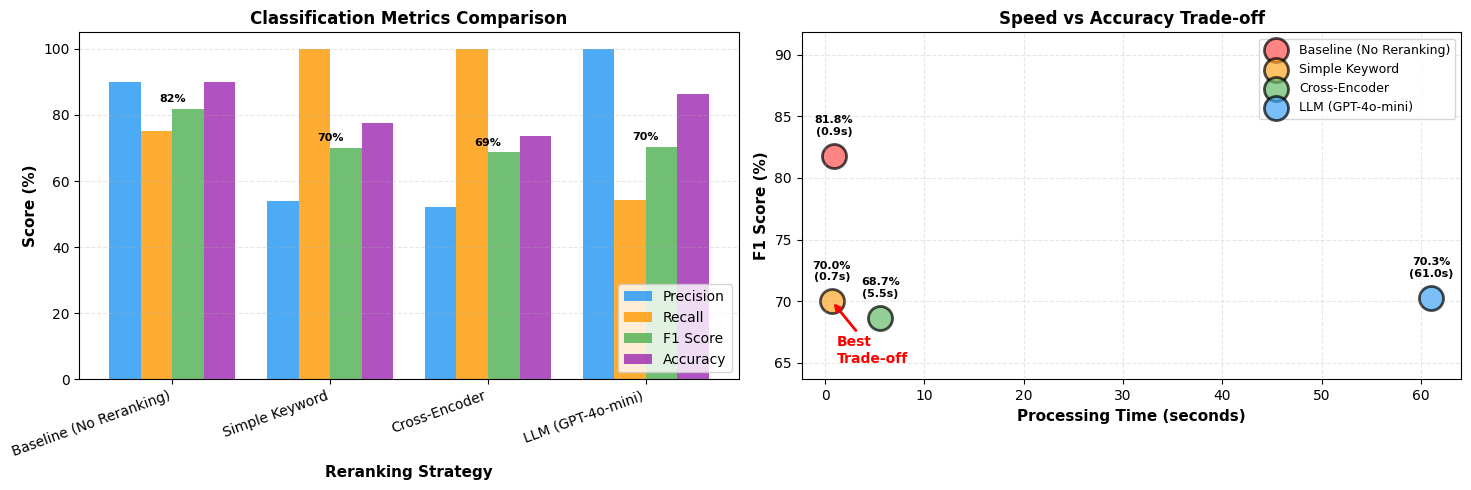


💡 Chart Interpretation:
   Left: Metrics across strategies (higher = better)
   Right: Speed-accuracy trade-off (top-left = ideal: high F1, low time)


In [153]:
# Create performance comparison visualizations
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

strategy_names = [name for name, _ in reranking_strategies]
precisions = [reranking_results[name]['precision'] * 100 for name in strategy_names]
recalls = [reranking_results[name]['recall'] * 100 for name in strategy_names]
f1_scores = [reranking_results[name]['f1'] * 100 for name in strategy_names]
accuracies = [reranking_results[name]['accuracy'] * 100 for name in strategy_names]
times = [reranking_results[name]['time'] for name in strategy_names]

# Plot 1: Metrics comparison bar chart
x = np.arange(len(strategy_names))
width = 0.2

axes[0].bar(x - 1.5*width, precisions, width, label='Precision', color='#2196F3', alpha=0.8)
axes[0].bar(x - 0.5*width, recalls, width, label='Recall', color='#FF9800', alpha=0.8)
axes[0].bar(x + 0.5*width, f1_scores, width, label='F1 Score', color='#4CAF50', alpha=0.8)
axes[0].bar(x + 1.5*width, accuracies, width, label='Accuracy', color='#9C27B0', alpha=0.8)

axes[0].set_xlabel('Reranking Strategy', fontweight='bold', fontsize=11)
axes[0].set_ylabel('Score (%)', fontweight='bold', fontsize=11)
axes[0].set_title('Classification Metrics Comparison', fontweight='bold', fontsize=12)
axes[0].set_xticks(x)
axes[0].set_xticklabels(strategy_names, rotation=20, ha='right')
axes[0].legend(loc='lower right')
axes[0].grid(axis='y', alpha=0.3, linestyle='--')
axes[0].set_ylim([0, 105])

# Add F1 value labels
for i, v in enumerate(f1_scores):
    axes[0].text(i, v + 2, f"{v:.0f}%", ha='center', fontsize=8, fontweight='bold')

# Plot 2: Speed vs F1 Score scatter plot
colors = ['#FF5252', '#FFA726', '#66BB6A', '#42A5F5']
for i, name in enumerate(strategy_names):
    axes[1].scatter(times[i], f1_scores[i], s=300, alpha=0.7,
                   c=colors[i], label=name, edgecolors='black', linewidth=2)
    # Add annotations
    axes[1].annotate(f"{f1_scores[i]:.1f}%\n({times[i]:.1f}s)",
                    (times[i], f1_scores[i]),
                    textcoords="offset points",
                    xytext=(0, 15),
                    ha='center',
                    fontsize=8,
                    fontweight='bold')

axes[1].set_xlabel('Processing Time (seconds)', fontweight='bold', fontsize=11)
axes[1].set_ylabel('F1 Score (%)', fontweight='bold', fontsize=11)
axes[1].set_title('Speed vs Accuracy Trade-off', fontweight='bold', fontsize=12)
axes[1].legend(loc='best', fontsize=9)
axes[1].grid(True, alpha=0.3, linestyle='--')
axes[1].set_ylim([min(f1_scores) - 5, max(f1_scores) + 10])

# Highlight best trade-off (best F1/time ratio)
ratios = [f1 / max(t, 0.1) for f1, t in zip(f1_scores, times)]
best_idx = ratios.index(max(ratios))
axes[1].annotate('Best\nTrade-off',
                xy=(times[best_idx], f1_scores[best_idx]),
                xytext=(times[best_idx] + 0.5, f1_scores[best_idx] - 5),
                arrowprops=dict(arrowstyle='->', color='red', lw=2),
                fontsize=10, fontweight='bold', color='red')

plt.tight_layout()
plt.show()

print("\n💡 Chart Interpretation:")
print("   Left: Metrics across strategies (higher = better)")
print("   Right: Speed-accuracy trade-off (top-left = ideal: high F1, low time)")

In [154]:
print("\n" + "="*90)
print("💡 KEY INSIGHTS: RERANKING STRATEGIES")
print("="*90)
print("""
1. BASELINE (NO RERANKING):
   ✅ Pros: Fastest, simplest implementation
   ❌ Cons: Higher false positive rate, returns semantically similar but wrong results
   📊 Use when: Speed is critical, false positives are acceptable

2. SIMPLE KEYWORD RERANKER:
   ✅ Pros: Fast, interpretable, no external dependencies
   ❌ Cons: Limited semantic understanding, misses paraphrases
   📊 Use when: Queries have predictable keyword patterns

3. CROSS-ENCODER RERANKER:
   ✅ Pros: Good semantic understanding, balanced speed/accuracy
   ❌ Cons: Model loading overhead, GPU recommended
   📊 Use when: Production systems need reliable accuracy

4. LLM RERANKER (GPT-4o-mini):
   ✅ Pros: Highest precision, provides reasoning, handles edge cases
   ❌ Cons: Slowest, API costs, requires internet
   📊 Use when: Accuracy is critical (medical, legal, financial)

📈 PERFORMANCE SUMMARY:
""")

# Find best by each metric
best_precision = max(reranking_strategies, key=lambda x: reranking_results[x[0]]['precision'])
best_recall = max(reranking_strategies, key=lambda x: reranking_results[x[0]]['recall'])
best_f1 = max(reranking_strategies, key=lambda x: reranking_results[x[0]]['f1'])
fastest = min(reranking_strategies, key=lambda x: reranking_results[x[0]]['time'])

print(f"   Best Precision: {best_precision[0]} ({reranking_results[best_precision[0]]['precision']:.1%})")
print(f"   Best Recall:    {best_recall[0]} ({reranking_results[best_recall[0]]['recall']:.1%})")
print(f"   Best F1:        {best_f1[0]} ({reranking_results[best_f1[0]]['f1']:.1%})")
print(f"   Fastest:        {fastest[0]} ({reranking_results[fastest[0]]['time']:.2f}s)")

print("""
🎯 RECOMMENDED APPROACH: TIERED ARCHITECTURE

   Tier 1: Semantic Cache (Recall Focus)
           ↓ Retrieve top-5 candidates
   
   Tier 2: Cross-Encoder (90% of queries)
           ↓ Fast, accurate validation
   
   Tier 3: LLM Reranking (10% uncertain cases)
           ↓ High-confidence validation
   
   Result: Cached response (validated) OR cache miss → LLM API call

Benefits:
  • Maximizes recall with semantic cache
  • Ensures precision with cross-encoder
  • Uses expensive LLM only when needed
  • Typical split: 70% cache hit, 20% cross-encoder validation, 10% LLM/miss
""")

print("="*90)


💡 KEY INSIGHTS: RERANKING STRATEGIES

1. BASELINE (NO RERANKING):
   ✅ Pros: Fastest, simplest implementation
   ❌ Cons: Higher false positive rate, returns semantically similar but wrong results
   📊 Use when: Speed is critical, false positives are acceptable

2. SIMPLE KEYWORD RERANKER:
   ✅ Pros: Fast, interpretable, no external dependencies
   ❌ Cons: Limited semantic understanding, misses paraphrases
   📊 Use when: Queries have predictable keyword patterns

3. CROSS-ENCODER RERANKER:
   ✅ Pros: Good semantic understanding, balanced speed/accuracy
   ❌ Cons: Model loading overhead, GPU recommended
   📊 Use when: Production systems need reliable accuracy

4. LLM RERANKER (GPT-4o-mini):
   ✅ Pros: Highest precision, provides reasoning, handles edge cases
   ❌ Cons: Slowest, API costs, requires internet
   📊 Use when: Accuracy is critical (medical, legal, financial)

📈 PERFORMANCE SUMMARY:

   Best Precision: LLM (GPT-4o-mini) (100.0%)
   Best Recall:    Simple Keyword (100.0%)
   Be